In [5]:
#import library
!pip install tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [6]:
#load dataset
df = pd.read_csv('ReviewTokoBaju (1).csv')

text_col = 'Review Text'
label_col = 'Recommended IND'

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[label_col] = le.fit_transform(df[label_col])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[text_col], df[label_col], test_size=0.2, random_state=42, stratify=df[label_col]
)


In [14]:
#padding

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')


X_train = X_train.astype(str).fillna('')
X_test = X_test.astype(str).fillna('')

tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [15]:
#dataloader
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = ReviewDataset(X_train_tensor, y_train_tensor)
test_data = ReviewDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [16]:
#Model RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out).squeeze()


vocab_size = max_words
embed_dim = 64
hidden_dim = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNModel(vocab_size, embed_dim, hidden_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
#Training
num_epochs = 10
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss, correct = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (outputs >= 0.5).float()
        correct += (preds == y_batch).sum().item()

    train_loss_hist.append(epoch_loss / len(train_loader))
    train_acc_hist.append(correct / len(train_loader.dataset))

    # Eval mode
    model.eval()
    test_loss, correct = 0, 0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            correct += (preds == y_batch).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    test_loss_hist.append(test_loss / len(test_loader))
    test_acc_hist.append(correct / len(test_loader.dataset))
    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc_hist[-1]:.4f} | Test Acc: {test_acc_hist[-1]:.4f}")


Epoch 1/10 - Train Acc: 0.8196 | Test Acc: 0.8223
Epoch 2/10 - Train Acc: 0.8224 | Test Acc: 0.8223
Epoch 3/10 - Train Acc: 0.8224 | Test Acc: 0.8223
Epoch 4/10 - Train Acc: 0.8224 | Test Acc: 0.8223
Epoch 5/10 - Train Acc: 0.8223 | Test Acc: 0.8223
Epoch 6/10 - Train Acc: 0.8226 | Test Acc: 0.8223
Epoch 7/10 - Train Acc: 0.8220 | Test Acc: 0.8223
Epoch 8/10 - Train Acc: 0.8224 | Test Acc: 0.8223
Epoch 9/10 - Train Acc: 0.8229 | Test Acc: 0.8216
Epoch 10/10 - Train Acc: 0.8233 | Test Acc: 0.8212


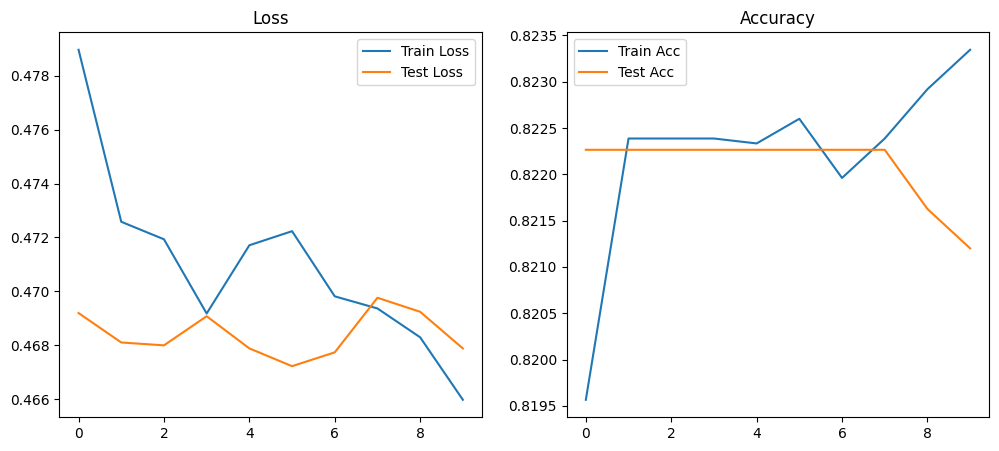

In [18]:
#visualisasi
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(test_acc_hist, label='Test Acc')
plt.title("Accuracy")
plt.legend()

plt.show()


Accuracy: 0.8212005108556832
Precision: 0.8226254002134472
Recall: 0.9976702045042712
F1 Score: 0.9017313991576977
AUC-ROC: 0.5079485863892199


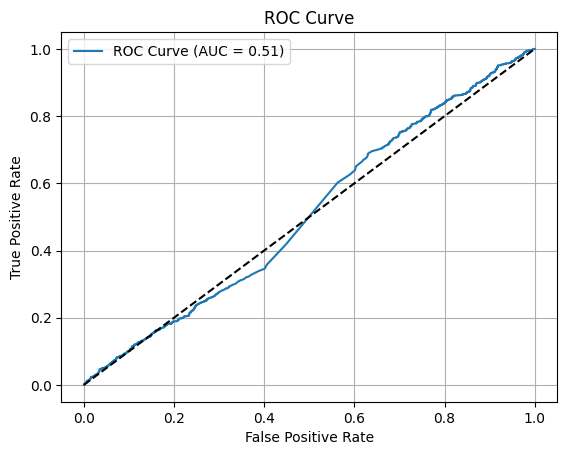

In [19]:
#evaluasi
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds))
print("Recall:", recall_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds))
print("AUC-ROC:", roc_auc_score(all_labels, all_probs))

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.grid()
plt.show()


**Berikut penjelasan persamaan penting:**

* **Binary Crossentropy Loss:**

  $$
  \mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1 - y_i)\log(1 - \hat{y}_i)]
  $$

  → Mengukur seberapa baik prediksi $\hat{y}_i$ terhadap label asli $y_i$.

* **Akurasi:**

  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$

* **Presisi:**

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

* **Recall:**

  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

* **F1-Score:**

  $$
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

* **AUC-ROC** adalah area di bawah kurva ROC: representasi trade-off antara TPR dan FPR.

**Analisis Hasil Model**

**Akurasi & Loss**

* **Train Accuracy**: \~82.3%

* **Test Accuracy**: \~82.2%
  ➡ Ini cukup stabil dan **tidak overfitting**


**Precision, Recall, F1**

* **Precision**: 82.3% → model cukup baik dalam prediksi positif tanpa banyak false positive.
* **Recall**: 99.7% → model hampir semua kasus positif berhasil ditangkap (hampir tidak ada false negative).
* **F1 Score**: 90.1% → gabungan precision & recall sangat bagus.





**AUC-ROC**

* **AUC: 0.51**
  ➡ Ini sangat mendekati **0.5 → model random guess**.
  ROC curve juga nyaris diagonal, artinya model **tidak bisa membedakan kelas positif & negatif secara baik**, meskipun metrik lainnya kelihatan tinggi.


